# Table of Contents
- [Major Classes and File Parsing](#Major-Classes-and-File-Parsing)
- [Load the Data](#Load-the-Data)
- [Signal Exploration](#Signal-Exploration)
- [Classification Experiments](#Classification-Experiments)
- [Visualizing Results](#Visualizing-Results)
- [Sandbox](#Sandbox)

# Overview
This Jupyter Notebook provides you with some basic scaffolding to get you started on the [A3: Gesture Recognizer assignment](https://canvas.uw.edu/courses/1319205/assignments/5021143). In particular, I wrote some parser code and some initial data structures to parse and load the gesture logs recorded with the [A3: Gesture Recorder](https://github.com/jonfroehlich/CSE599Au2019/tree/master/Assignments/A3-Gesture/GestureRecorder).

Importantly, for this assignment, you will be working with **pre-segmented** data based on how you collected data with the GestureRecorder.

## Where to Put Your Log Files
You must have your gesture logs in a folder called `GestureLogs` which resides in the same directory as this `.ipynb`. Inside of `GestureLogs`, you should have one or more sub-directories like `JonGestureLogs` or `JesseGestureLogs` that was created by the `GestureRecorder.pde.` 

## Data Structures
There are three primary objects:
1. At the top level, we have a `GestureSet`, which contains all of the gesture data for a person
2. Each `GestureSet` object contains a `dict()` mapping gesture names to trials (recall that in the assignment, you had to collect 5 trials of 11 gestures)
3. Each `Trial` object contains the sensor data (`SensorData`) for that trial, which is the accelerometer data (x, y, z, and a computed magnitude)

Given that there can be multiple loaded gesture sets, we have a global object called `map_gesture_sets` that maps the `GestureSet.name` to the `GestureSet` object.

# Your TODOs
1. You need to **visualize and explore** the data
2. Think about, experiment, and write code for **preprocessing** the data (see **CSE599TODO**)
3. Think about, experiment, and write code for **comparing two signals**
4. Think about, experiment, and write code infrastructure for **setting up and running experiments** (e.g., k-fold cross validation and confusion matrices)
5. Run the experiments and write-up your results.

## Dynamic Time Warping
If you choose to explore Dynamic Time Warping (DTW), I recommend fastdtw. You can install this by typing the following in cell:
```
import sys
!{sys.executable} -m pip install fastdtw
```
See https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/ for more details

## Major Classes and File Parsing

In [ ]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
import scipy as sp
from scipy import signal
import random

# Each accelerometer log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensor_type, which is a str
    def __init__(self, sensor_type, current_time_ms, sensor_timestamp_ms, x, y, z):
        self.sensor_type = sensor_type
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.current_time_ms = current_time_ms.astype(np.int64)
        
        # sensor_timestamp_ms comes from the Arduino function 
        # https://www.arduino.cc/reference/en/language/functions/time/millis/
        # which returns the number of milliseconds passed since the Arduino board began running the current program.
        self.sensor_timestamp_ms = sensor_timestamp_ms.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        # Calculate the magnitude of the signal
        self.mag = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        
        self.sample_length_in_secs = (self.current_time_ms[-1] - self.current_time_ms[0]) / 1000.0
        self.sampling_rate = len(self.current_time_ms) / self.sample_length_in_secs 
        
    # Returns a dict of numpy arrays for each axis of the accel + magnitude
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Returns a dict of numpy arrays for each axis of the accel + magnitude
    def get_processed_data(self):
        return {"x_p":self.x_p, "y_p":self.y_p, "z_p":self.z_p, "mag_p":self.mag_p}
    
    # Preprocesses all of the signals (x, y, z, and mag) and stores them in
    # self.x_p, self.y_p, self.z_p, and self.mag_p
    def preprocess(self, max_array_length = -1):
        self.x_p = self.__preprocess(self.x, max_array_length)
        self.y_p = self.__preprocess(self.y, max_array_length)
        self.z_p = self.__preprocess(self.z, max_array_length)
        self.mag_p = self.__preprocess(self.mag, max_array_length)
    
    # Private function to preprocess the signals
    def __preprocess(self, raw_signal, max_array_length = -1):
        # CSE599TODO: You'll want to loop through the sensor signals and preprocess them
        # Some things to explore: padding signal to equalize length between trials, smoothing, detrending, and scaling
  
        # For example, this code smooths the signal using a median filter 
        # https://en.wikipedia.org/wiki/Median_filter#Worked_1D_example
        # Note: a mean filter would work better :)
        med_filter_window_size = 9
        processed_signal = signal.medfilt(raw_signal, med_filter_window_size)
 
        return processed_signal

# A trial is one gesture recording and includes an accel SensorData object
# In the future, this could be expanded to include other recorded sensors (e.g., a gyro)
# that may be recorded simultaneously
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gesture_name, end_time_ms, trial_num, log_filename_with_path):
        self.gesture_name = gesture_name
        self.trial_num = trial_num
        self.end_time_ms = end_time_ms
        self.log_filename_with_path = log_filename_with_path
        self.log_filename = os.path.basename(log_filename_with_path)
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsed_accel_log_data = np.genfromtxt(log_filename_with_path, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsed_accel_log_data)
    
    # Preprocesses the sensor data in the trial
    def preprocess(self, max_array_length = -1):
        self.accel.preprocess(max_array_length)
        
    # Gets the length of the trial in samples
    def length(self):
        return len(self.accel.x)
    
    # Utility function that returns the end time as a nice string
    def get_end_time_as_string(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.end_time_ms / 1000))
    
    def __str__(self):
         return "'{}' : Trial {} from {}".format(self.gesture_name, self.trial_num, self.log_filename)

# Container for a single set of gestures and trials
class GestureSet:
    
    # After calling the constructor, you must called *load* and then *preprocess*
    def __init__(self, gesture_log_path):
        self.path = gesture_log_path
        self.name = self.get_base_path()
        
    # loads the gesture trials
    def load(self):
        # Our primary object tha maps a gesture name to a list of Trial objects
        self.map_gestures_to_trials = self.__parse_gesture_trials(self.path)
    
    # preprocesses the gesture trials
    def preprocess(self):
        longest_trial_length = self.get_longest_trial().length()
        print("longest_trial_length", longest_trial_length)
        for gesture_name, trials in self.map_gestures_to_trials.items():
            for trial in trials:
                trial.preprocess(longest_trial_length)
    
    # Parses and creates Trial objects for all csv files in the given dir
    # Returns a dict() mapping (str: gesture_name) to (list: Trial objects)
    # It's not necessary that you understand this code
    def __parse_gesture_trials(self, path_to_dir ):
        csv_filenames = find_csv_filenames(path_to_dir)

        print("Found {} csv files in {}".format(len(csv_filenames), path_to_dir))

        map_gesture_name_to_trial_list = dict()
        map_gesture_name_to_map_endtime_to_map_sensor_to_file = dict() # use this to correctly order trials
        for csvFilename in csv_filenames:

            # parse filename into meaningful parts
            # print(csvFilename)
            filename_no_ext = os.path.splitext(csvFilename)[0];

            filename_parts = filename_no_ext.split("_")
            gesture_name = None
            time_ms = None
            num_rows = None
            sensor_name = "Accelerometer" # currently only one sensor but could expand to more

            # Added this conditional on May 15, 2019 because Windows machines created differently formatted
            # filenames from Macs. Windows machines automatically replaced the character "'"
            # with "_", which affects filenames like "Midair Zorro 'Z'_1556730840228_206.csv"
            # which come out like "Midair Zorro _Z__1557937136974_211.csv" instead
            if '__' in filename_no_ext:
                filename_parts1 = filename_no_ext.split("__")
                gesture_name = filename_parts1[0]
                gesture_name = gesture_name.replace('_',"'")
                gesture_name += "'"

                filename_parts2 = filename_parts1[1].split("_")
                time_ms = filename_parts2[0]
                num_rows = filename_parts2[1]
            else:
                filename_parts = filename_no_ext.split("_")
                gesture_name = filename_parts[0]
                time_ms = filename_parts[1]
                num_rows = int(filename_parts[2])

            # print("gesture_name={} time_ms={} num_rows={}".format(gesture_name, time_ms, num_rows))

            if gesture_name not in map_gesture_name_to_map_endtime_to_map_sensor_to_file:
                map_gesture_name_to_map_endtime_to_map_sensor_to_file[gesture_name] = dict()

            if time_ms not in map_gesture_name_to_map_endtime_to_map_sensor_to_file[gesture_name]:
                map_gesture_name_to_map_endtime_to_map_sensor_to_file[gesture_name][time_ms] = dict()

            map_gesture_name_to_map_endtime_to_map_sensor_to_file[gesture_name][time_ms][sensor_name] = csvFilename
            # print (map_gesture_name_to_map_endtime_to_map_sensor_to_file)

        print("Found {} gestures".format(len(map_gesture_name_to_map_endtime_to_map_sensor_to_file)))

        # track the longest array
        max_array_length = -1
        trial_with_most_sensor_events = None

        # Now we need to loop through the data and sort each gesture set by timems values 
        # (so that we have trial 1, 2, 3, etc. in order)
        for gesture_name, map_endtime_to_map_sensor_to_file in map_gesture_name_to_map_endtime_to_map_sensor_to_file.items():
            gesture_trial_num = 0
            map_gesture_name_to_trial_list[gesture_name] = list()
            for end_time_ms in sorted(map_endtime_to_map_sensor_to_file.keys()):
                map_sensor_to_file = map_endtime_to_map_sensor_to_file[end_time_ms]

                log_filename_with_path = os.path.join(path_to_dir, map_sensor_to_file["Accelerometer"])
                gesture_trial = Trial(gesture_name, end_time_ms, gesture_trial_num, log_filename_with_path)
                map_gesture_name_to_trial_list[gesture_name].append(gesture_trial)

                if max_array_length < len(gesture_trial.accel.x):
                    max_array_length = len(gesture_trial.accel.x)
                    trial_with_most_sensor_events = gesture_trial

                gesture_trial_num = gesture_trial_num + 1

            print("Found {} trials for '{}'".format(len(map_gesture_name_to_trial_list[gesture_name]), gesture_name))

        # Print out some basic information about our logs
        print("Max trial length across all gesture is '{}' Trial {} with {} sensor events.".
              format(trial_with_most_sensor_events.gesture_name, trial_with_most_sensor_events.trial_num, max_array_length))
        list_samples_per_second = list()
        list_total_sample_time = list()
        for gesture_name, trial_list in map_gesture_name_to_trial_list.items():
            for trial in trial_list: 
                list_samples_per_second.append(trial.accel.sampling_rate)
                list_total_sample_time.append(trial.accel.sample_length_in_secs)

        print("Avg samples/sec across {} sensor files: {:0.1f}".format(len(list_samples_per_second), sum(list_samples_per_second)/len(list_samples_per_second)))
        print("Avg sample length across {} sensor files: {:0.1f}s".format(len(list_total_sample_time), sum(list_total_sample_time)/len(list_total_sample_time)))
        print()
        return map_gesture_name_to_trial_list
    
    # returns the longest trial (based on num rows recorded and not clock time)
    def get_longest_trial(self):
        longest_trial_length = -1
        longest_trial = None
        for gesture_name, trial_list in self.map_gestures_to_trials.items():
            for trial in trial_list:
                if longest_trial_length < len(trial.accel.x):
                    longest_trial_length = len(trial.accel.x)
                    longest_trial = trial
        return longest_trial
    
    # returns the base path
    def get_base_path(self):
        return os.path.basename(os.path.normpath(self.path))
    
    # returns the number of gestures
    def get_num_gestures(self):
        return len(self.map_gestures_to_trials)
    
    # returns trials for a gesture name
    def get_trials_for_gesture(self, gesture_name):
        return self.map_gestures_to_trials[gesture_name]
    
    # Creates an aggregate signal based on *all* trials for this gesture
    # There are *tons* of methods to create an aggregate signal. This one
    # is super basic: simply tries to align the signals and then takes the mean
    # Note: function currently assumes all trials are the same length
    # Would need to update to handle different sized signals
    def create_aggregate_signal(self, gesture_name, signal_var_name):
        trials = self.get_trials_for_gesture(gesture_name)
        aggregate_signal = None
        trial_signals = []
        trial_signals_original = []
        first_trial = None
            
        for i in range(len(trials)):
            if i == 0:
                first_trial = trials[i]
                trial_signal = getattr(first_trial.accel, signal_var_name)
                trial_signal_mod = np.copy(trial_signal)

                trial_signals.append(trial_signal_mod)
                trial_signals_original.append(trial_signal)

                aggregate_signal = trial_signal_mod
            else:

                trial1 = first_trial # used for alignment
                trial2 = trials[i]

                trial1_signal = getattr(trial1.accel, signal_var_name)
                trial2_signal = getattr(trial2.accel, signal_var_name) 
                trial_signals_original.append(trial2_signal)

                trial2_signal_shifted = get_aligned_signal_cutoff_and_pad(trial2_signal, trial1_signal)
                trial_signals.append(trial2_signal_shifted)
                aggregate_signal += trial2_signal_shifted
        
        mean_signal = aggregate_signal / len(trial_signals) 
        return mean_signal

    # Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
    # different number. We should have the same number of trials across all gestures)
    def get_min_num_of_trials(self):
        min_num_trials = -1 
        for gesture_name, trials in self.map_gestures_to_trials.items():
            if min_num_trials == -1 or min_num_trials > len(trials):
                min_num_trials = len(trials)
        return min_num_trials

    # returns the total number of trials
    def get_total_num_of_trials(self):
        numTrials = 0 
        for gesture_name, trialSet in self.map_gestures_to_trials.items():
            numTrials = numTrials + len(trialSet)
        return numTrials
    
    # get random gesture name
    def get_random_gesture_name(self):
        gesture_names = list(self.map_gestures_to_trials.keys())
        rand_gesture_name = gesture_names[random.randint(0, len(gesture_names) - 1)]
        return rand_gesture_name
    
    # get random trial for gesture
    def get_random_trial_for_gesture(self, gesture_name):
        trials_for_gesture = self.map_gestures_to_trials[gesture_name]
        return trials_for_gesture[random.randint(0, len(trials_for_gesture) - 1)]
    
    # get random trial
    def get_random_trial(self):
        rand_gesture_name = self.get_random_gesture_name()
        print("rand_gesture_name", rand_gesture_name)
        trials_for_gesture = self.map_gestures_to_trials[rand_gesture_name]
        return trials_for_gesture[random.randint(0, len(trials_for_gesture) - 1)]
    
    # returns a sorted list of gesture names
    def get_gesture_names_sorted(self):
        return sorted(self.map_gestures_to_trials.keys())
    
    # prettify the str()
    def __str__(self):
         return "'{}' : {} gestures and {} total trials".format(self.path, self.get_num_gestures(), self.get_total_num_of_trials())
        

In [ ]:
# This cell contains some utility functions for file handling, parsing, and signal processing
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
# Currently excludes any filenames with 'fulldatastream' in the title
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) and "fulldatastream" not in filename ]
    
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# From: https://stackoverflow.com/questions/800197/how-to-get-all-of-the-immediate-subdirectories-in-python
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

# Gets a random gesture set
def get_random_gesture_set(map_gesture_sets):
    gesture_set_names = list(map_gesture_sets.keys())
    rand_gesture_set_name = gesture_set_names[random.randint(0, len(gesture_set_names) - 1)]
    return map_gesture_sets[rand_gesture_set_name]

# Get a gesture set containing name. If none exists, returns None
# If multiple matches, no guarantee about which one will be returned
def get_gesture_set_containing_name(map_gesture_sets, gesture_set_name_query):
    gesture_set_names = list(map_gesture_sets.keys())
    gesture_set_name_query = gesture_set_name_query.lower()
    for gesture_set_name in gesture_set_names:
        if gesture_set_name_query in gesture_set_name.lower():
            return map_gesture_sets[gesture_set_name]
    return None

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gesture_name = filename[:tokenSplitPos]
    return gesture_name

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( map_gesture_to_trials ):
    min_num_trials = -1 
    for gesture_name, trial_set in map_gesture_to_trials.items():
        if min_num_trials == -1 or min_num_trials > len(trial_set):
            min_num_trials = len(trial_set)
    return min_num_trials

# returns the total number of trials
def get_total_num_of_trials (map_gesture_to_trials):
    numTrials = 0 
    for gesture_name, trialSet in map_gesture_to_trials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

# Helper function to align signals. 
# Returns a shifted signal of a based on cross correlation and a roll function
def get_aligned_signal(a, b):
    corr = signal.correlate(a, b, mode='full')
    index_shift = len(a) - np.argmax(corr)
    a_shifted = np.roll(a, index_shift - 1) 
    return a_shifted

# Returns a shifted signal of a based on cross correlation and padding
def get_aligned_signal_cutoff_and_pad(a, b):
    corr = signal.correlate(a, b, mode='full')
    index_shift = len(a) - np.argmax(corr)
    index_shift_abs = abs(index_shift - 1)
    a_shifted_cutoff = None
    if (index_shift - 1) < 0:
        a_shifted_cutoff = a[index_shift_abs:]
        a_shifted_cutoff = np.pad(a_shifted_cutoff, (0, index_shift_abs), 'mean')
    else:
        a_shifted_cutoff = np.pad(a, (index_shift_abs,), 'mean')
        a_shifted_cutoff = a_shifted_cutoff[:len(a)]
    return a_shifted_cutoff

# Aligns two signals of unequal sizes using cross-correlation. The two signals are then
# trimmed to be equivalent sizes
# For size equalization, the smaller array is first padded
def get_aligned_signals_ablate(a, b):
    if len(a) > len(b):
        a_cutoff, b_cutoff = get_aligned_signals_ablate(b, a)
        return (b_cutoff, a_cutoff)
    
    original_a_len = len(a)
    a_padded = a
    
    if len(a) < len(b): # this should always be true unless a == b
        len_diff = len(b) - len(a)
        a_padded = np.pad(a, (0, len_diff), mode='constant', constant_values=0)
        #a_padded = np.pad(a, (0, len_diff), mode='mean') # doesn't work with 'mean'
        
    corr_result_ab = signal.correlate(a_padded,b)
    best_correlation_point = np.argmax(corr_result_ab)
    
    index_shift = len(a_padded) - np.argmax(corr_result_ab) - 1
    index_shift_abs = abs(index_shift)
    #print("best_correlation_point", best_correlation_point, "index_shift", index_shift)
    
    if index_shift >= 0:
        a_shifted = np.pad(a_padded, (index_shift, 0), mode='constant', constant_values=0) # right shift, pad with 0
        a_cutoff = a_shifted[0:len(a_shifted) - (len(a_padded) - len(a))]
        a_cutoff = a_cutoff[index_shift:index_shift + len(a)]
        b_cutoff = b[index_shift:index_shift + len(a)]
    else:
        #print("index less than 0")
        a_shifted = a_padded[index_shift_abs:len(a_padded)] # left shift via ablation
        a_cutoff = a_shifted[0:len(a_shifted) - (len(a_padded) - len(a))] # cut off remaining right side
        b_cutoff = b[0:len(a_cutoff)]
    
    #print("original lengths", len(a), len(b), "cutoff lengths:", len(a_cutoff), len(b_cutoff))
    return (a_cutoff, b_cutoff)

## Load the Data

In [ ]:
# Load the data
root_gesture_log_path = './GestureLogs'
print(get_immediate_subdirectories(root_gesture_log_path))
gesture_log_paths = get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()
selected_gesture_set = None
for gesture_log_path in gesture_log_paths:
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    print("Creating a GestureSet object for path '{}'".format(path_to_gesture_log))
    gesture_set = GestureSet(path_to_gesture_log)
    gesture_set.load()
    gesture_set.preprocess();
    map_gesture_sets[gesture_set.name] = gesture_set

if selected_gesture_set is None:
    # Since we load multiple gesture sets and often want to just visualize and explore
    # one set, in particular, we set a selected_gesture_set variable here
    # Feel free to change this
    #selected_gesture_set = get_random_gesture_set(map_gesture_sets)
    selected_gesture_set = get_gesture_set_containing_name(map_gesture_sets, "Jon")

print("The selected gesture set:", selected_gesture_set)

def get_gesture_set_with_str(str):
    for base_path, gesture_set in map_gesture_sets.items():
        if str in base_path:
            return gesture_set
    return None

## Signal Exploration

In [ ]:
# Now, let's explore the data! We need to come up with a shape matching approach 
# and a trained model approach (e.g., decision tree, SVM) to classify the gestures

# For example, here's how you would plot one of the signals
rand_gesture_name = selected_gesture_set.get_random_gesture_name()

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(1, figsize=(10, 5)) #figsize is width, height
gesture_trials = selected_gesture_set.get_trials_for_gesture(rand_gesture_name)
trial_num = 0
for trial in gesture_trials:
    axes.plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trial_num))
    trial_num = trial_num + 1

# set the title and show the legend
axes.set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (Accel Mag)")
axes.legend()

In [ ]:
# Now let's plot both the raw and processed signal of a random gesture (and random trial of that gesture)
rand_gesture_name = selected_gesture_set.get_random_gesture_name()

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(1, 2, figsize=(20, 5)) #figsize is width, height
rand_trial = selected_gesture_set.get_random_trial_for_gesture(rand_gesture_name)

axes[0].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(rand_trial.trial_num))
axes[0].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (accel mag)")
axes[0].legend()

axes[1].plot(trial.accel.mag_p, alpha=0.7, label="Trial {}".format(rand_trial.trial_num))
axes[1].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (accel mag_p)")
axes[1].legend()

In [ ]:
# Now let's plot all of the accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(selected_gesture_set.map_gestures_to_trials), 4, 
                         figsize=(20, 3 * len(selected_gesture_set.map_gestures_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    gesture_trials = selected_gesture_set.get_trials_for_gesture(gesture_name)
    
    trial_num = 1
    for trial in gesture_trials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trial_num))
        trial_num = trial_num + 1
        
    axes[index][0].set_title(gesture_name + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gesture_name + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gesture_name + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gesture_name + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1

In [ ]:
# Now let's plot all of the accel signals, both raw and processed.

# We are going to make a grid of line graphs with:
# two rows for each gesture (one raw, one processed), so len(mapGestureToTrials) * 2 rows 
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(selected_gesture_set.map_gestures_to_trials) * 2, 4, 
                         figsize=(20, 5 * 2 * len(selected_gesture_set.map_gestures_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    gesture_trials = selected_gesture_set.get_trials_for_gesture(gesture_name)
    
    trial_num = 1
    for trial in gesture_trials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trial_num))
        
        axes[index + 1][0].plot(trial.accel.x_p, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index + 1][1].plot(trial.accel.y_p, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index + 1][2].plot(trial.accel.z_p, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index + 1][3].plot(trial.accel.mag_p, alpha=0.7, label="Trial {}".format(trial_num))
        
        trial_num = trial_num + 1
        
    axes[index][0].set_title(gesture_name + " (accel x)")
    axes[index][1].set_title(gesture_name + " (accel y)")
    axes[index][2].set_title(gesture_name + " (accel z)")
    axes[index][3].set_title(gesture_name + " (accel mag)")
    
    axes[index][0].legend()
    axes[index][1].legend()
    axes[index][2].legend()
    axes[index][3].legend()
    
    index = index + 1
    axes[index][0].set_title(gesture_name + " (accel x_p)")
    axes[index][1].set_title(gesture_name + " (accel y_p)")
    axes[index][2].set_title(gesture_name + " (accel z_p)")
    axes[index][3].set_title(gesture_name + " (accel mag_p)")
    
    axes[index][0].legend()
    axes[index][1].legend()
    axes[index][2].legend()
    axes[index][3].legend()
    
    index = index + 1

In [ ]:
# Or maybe we just want to focus on the magnitude of the signal. Is there enough visual salience in here
# that you think this signal alone is discriminable for classifying gestures?
map_gestures_to_trials = selected_gesture_set.map_gestures_to_trials
fig, axes = plt.subplots(len(map_gestures_to_trials), 2, figsize=(20, 5 * len(map_gestures_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
for gesture_name in selected_gesture_set.get_gesture_names_sorted():
    gesture_trials = map_gestures_to_trials[gesture_name]
    trial_num = 0
    for trial in gesture_trials:
        axes[index][0].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trial_num))
        axes[index][1].plot(trial.accel.mag_p, alpha=0.7, label="Trial {}".format(trial_num))
        trial_num = trial_num + 1
        
    axes[index][0].set_title(selected_gesture_set.name + ": Raw " + gesture_name + " (accel mag)")
    axes[index][0].legend()
    
    axes[index][1].set_title(selected_gesture_set.name + ": Processed " + gesture_name + " (accel mag_p)")
    axes[index][1].legend()

    index = index + 1


# Classification Experiments

In [ ]:
# Start analyzing and comparing these gesture signals.
# Think about:
#  - What patterns do you see in the data?
#  - What kind of filtering might be useful?
#  - How can you best align the signals for comparison? (e.g., hint: scroll down to see the Euclidean distance comparisons)
#  - What kind of signal transforms might be useful? (e.g., ffts, derivative waveforms)
#  - What is the simplest way we can compare two signals?
#  - What classes might you want to create to help you keep things organized? (e.g., your k-fold experiments and results)
#  - For k-fold cross validation, check out: http://scikit-learn.org/stable/modules/cross_validation.html or implement your own


In [34]:
# I've provided a bit of scaffolding and example classes to help you run experiments
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix
import random
import time

class ClassificationResults:
    
    def __init__(self, matching_alg_name, map_gesture_name_to_list_results, **kwargs):
        '''
        matching_alg_name: the name of the matching alg used for result
        map_gesture_name_to_list_results : a map of gesture name to list of TrialClassificationResults
        '''
        self.matching_alg_name = matching_alg_name
        self.map_gesture_name_to_list_results = map_gesture_name_to_list_results
    
        self.total_time = 0 # in seconds
        self.total_num_comparisons = 0
        self.total_correct = 0
        self.title = "No title yet"
        self.kwargs = kwargs # optional args
        
        for gesture_name, list_results in map_gesture_name_to_list_results.items():
            self.total_num_comparisons += len(list_results)
            for result in list_results: 
                self.total_time += result.elapsed_time
                if result.is_correct:
                    self.total_correct += 1
    
    def get_avg_time_per_comparison(self):
        '''
        Returns the average time per comparison
        '''
        return self.total_time / self.total_num_comparisons
    
    def get_gesture_names(self):
        '''
        Returns a sorted list of gesture names
        '''
        return sorted(self.map_gesture_name_to_list_results.keys())
    
    def get_accuracy(self):
        '''
        Returns the accuracy (which is number correct over number total comparisons)
        '''
        return self.total_correct / self.total_num_comparisons
   
    def get_num_correct_for_gesture(self, gesture_name):
        '''
        Returns the number correct for this gesture
        '''
        list_results_for_gesture = self.map_gesture_name_to_list_results[gesture_name]
        correctness_cnt = 0
        for result in list_results_for_gesture:
            if result.is_correct:
                correctness_cnt += 1
                
        return correctness_cnt
    
    def get_title(self):
        '''
        Returns the title of this instance
        '''
        return "{}: {}/{} ({:0.2f}%)"\
              .format(self.title, self.total_correct, self.total_num_comparisons, self.get_accuracy() * 100)

    def get_correct_match_scores_for_gesture(self, gesture_name):
        '''
        Returns a list of scores for the correct matches for this gesture
        '''
        results_for_gesture = self.map_gesture_name_to_list_results[gesture_name]
        correct_scores = [result.score for result in results_for_gesture if result.is_correct]
        return correct_scores
    
    def get_incorrect_match_scores_for_gesture(self, gesture_name):
        '''
        Returns a list of scores for the incorrect matches for this gesture
        '''
        results_for_gesture = self.map_gesture_name_to_list_results[gesture_name]
        incorrect_scores = [result.score for result in results_for_gesture if not result.is_correct]
        return incorrect_scores
    
    def get_correct_match_indices_in_nbestlist_for_gesture(self, gesture_name):
        '''
        Returns a list of correct match indices in the n-best list for the given gesture
        '''
        results = self.map_gesture_name_to_list_results[gesture_name]
        correct_match_indices = [result.get_correct_match_index_nbestlist() for result in results]
        return correct_match_indices
    
    def get_confusion_matrix(self):
        '''
        Returns a scikit learn confusion matrix
        See: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
        '''
        y_true = list()
        y_pred = list()
        for gesture_name, list_results in self.map_gesture_name_to_list_results.items():
            for result in list_results:
                y_true.append(result.test_trial.gesture_name)
                y_pred.append(result.closest_trial.gesture_name)

        cm_classes = self.get_gesture_names()
        cm = confusion_matrix(y_true, y_pred, labels=cm_classes)
        return cm
    
    # Utility function to print results
    def print_result(self):
        print()
        print("Title:", self.get_title())
        print("Optional arguments:", self.kwargs)
        print("Took {:0.3f}s for {} comparisons (avg={:0.3f}s per match)"
              .format(self.total_time, self.total_num_comparisons, self.get_avg_time_per_comparison()))
        
        for gesture_name in self.get_gesture_names():
            correctness_cnt_for_gesture = self.get_num_correct_for_gesture(gesture_name)
            num_comparisons_for_gesture = len(self.map_gesture_name_to_list_results[gesture_name])
            print("- {} {}/{} ({}%)".format(gesture_name, correctness_cnt_for_gesture, num_comparisons_for_gesture, 
                                            correctness_cnt_for_gesture/num_comparisons_for_gesture * 100))
        
        print(self.get_confusion_matrix())
    
class TrialClassificationResult:
    def __init__(self, test_trial, n_best_list_sorted):
        self.test_trial = test_trial
        self.n_best_list_sorted = n_best_list_sorted
        self.closest_trial = n_best_list_sorted[0][0]
        self.score = n_best_list_sorted[0][1]
        self.is_correct = test_trial.gesture_name == self.closest_trial.gesture_name
        
        self.fold_idx = -1
        self.elapsed_time = -1 # elapsed time in seconds
        
    def get_correct_match_index_nbestlist(self):
        '''
        Returns the index of the correct match in the n-best list
        '''
        index = 0
        for fold_trial, score in self.n_best_list_sorted:
            if self.test_trial.gesture_name == fold_trial.gesture_name:
                return index
            index += 1    
        return -1
        
    def __str__(self):
        correctness_str = "Correct" if self.is_correct else "Incorrect"
        return("{} : Best match for '{}' Trial {} is '{}' Trial {} w/score: {:0.1f} ({:0.3f}s)".format(
                     correctness_str, self.test_trial.gesture_name, self.test_trial.trial_num, 
                     self.closest_trial.gesture_name, self.closest_trial.trial_num, 
                     self.score, self.elapsed_time))
        

def generate_kfolds(num_folds, gesture_set, seed=None):
    '''
    Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial 
    for that fold. To generate the same fold structure, pass in the same seed value (this is useful for
    setting up experiments)
    
    num_folds : the number of folds
    gesture_set : the gesture set for splitting into k-folds
    seed : an integer seed value (pass in the same seed value to get the same split across multiple executions)
    '''
    
    # Quick check to make sure that there are numFolds of gesture trials for each gesture
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        if num_folds != len(trials):
            raise ValueError("For the purposes of this assignment, the number of folds={} must equal the number of trials for each gesture. Gesture '{}' has {} trials"
                             .format(num_folds, gesture_name, len(trials)))
            
    # CSE599TODO
    list_folds = [] 
    
    return list_folds # each index of the list represents a fold, which contains a map of gesture names to trials

def print_folds(list_folds):
    '''
    Prints out the folds (useful for debugging)
    '''
    # print out folds (for debugging)
    fold_index = 0
    if fold_index == 0:
        for fold in list_folds:
            print("Fold: ", fold_index)
            for gesture_name, trial in fold.items():
                print("\t{} Trial: {}".format(gesture_name, trial.trial_num))
            fold_index = fold_index + 1

def run_matching_algorithm(list_folds, find_closest_match_alg, **kwargs):
    '''
    Our primary matching algorithm function that takes in a fold, a matching algorithm, and optional 
    arguments (**kwargs) for that matching alg. Returns a ClassificationResults object
    
    list_folds : the folds generated by generate_kfolds
    find_closest_match_alg : "pointer" to the closest match function you want to test
    kwargs : optional arguments to pass to find_closest_match_alg
    '''
    
    verbose = False
    if 'verbose' in kwargs:
        verbose = kwargs['verbose']
    
    fold_index = 0
    map_gesture_name_to_list_results = dict()
    for fold in list_folds:
        if verbose:
            print("\n**FOLD: {}**".format(fold_index))
            
        correctness_cnt_for_fold = 0
        elapsed_time_for_fold = 0
        for test_gesture_name, test_trial in fold.items():
            template_folds = list_folds[0:fold_index] + list_folds[fold_index + 1:len(list_folds)]
            
            start_time = time.time()
            trial_classification_result = find_closest_match_alg(test_trial, template_folds, **kwargs)
            elapsed_time_in_secs = time.time() - start_time
            trial_classification_result.fold_idx = fold_index
            trial_classification_result.elapsed_time = elapsed_time_in_secs
            elapsed_time_for_fold += elapsed_time_in_secs
            
            if trial_classification_result.is_correct:
                correctness_cnt_for_fold += 1
            
            if verbose:
                print(trial_classification_result)
            
            # track overall results across comparisons
            if test_gesture_name not in map_gesture_name_to_list_results:
                map_gesture_name_to_list_results[test_gesture_name] = list()
            map_gesture_name_to_list_results[test_gesture_name].append(trial_classification_result)
            
        # print out overall fold accuracy
        fold_accuracy = (correctness_cnt_for_fold / len(fold)) * 100;
        if verbose:
            print("COMPLETED FOLD: {} IN {:0.3f} SECS WITH ACCURACY {}/{} ({:0.1f}%)".
                  format(fold_index, elapsed_time_for_fold, correctness_cnt_for_fold, len(fold), fold_accuracy))

        fold_index = fold_index + 1
    
    classification_result = ClassificationResults(find_closest_match_alg.__name__, 
                                                  map_gesture_name_to_list_results, **kwargs)
    return classification_result
            
def find_closest_match_euclid_raw_x(test_trial, template_folds, **kwargs):
    '''
    Example closest match function using euclidean distance and the accelerometer X value
    Note: I'm not saying this is necessarily a *good* example but it should run :)
    Returns a TrialClassificationResult
    
    test_trial: the test trial
    template_folds: the current template folds
    kwargs: optional arguments for match function
    '''
    
    # Tuple list of trial to score
    n_best_list_tuple = list()
    for fold in template_folds:
        for template_gesture_name, template_trial in fold.items():

            # Calc euclidean distance
            # Euclidean distance requires that both arrays are the same length, so we must pad the shorter one
            test_trial_signal = test_trial.accel.x
            template_trial_signal = template_trial.accel.x
            if len(test_trial_signal) > len(template_trial_signal):
                array_length_diff = len(test_trial_signal) - len(template_trial_signal)
                template_trial_signal = np.pad(template_trial_signal, (0, array_length_diff), 'mean')
            elif len(template_trial_signal) > len(test_trial_signal):
                array_length_diff = len(template_trial_signal) - len(test_trial_signal)
                test_trial_signal = np.pad(test_trial_signal, (0, array_length_diff), 'mean')
            
            euclid_distance = distance.euclidean(test_trial_signal, template_trial_signal)

            # FYI: This is numpy's way of doing euclid distance
            # euclidDistance = np.linalg.norm(testTrial.accel.mag_p - foldTrial.accel.mag_p)
            
            n_best_list_tuple.append((template_trial, euclid_distance))
    
    # sort the nBestList by score
    n_best_list_tuple.sort(key=lambda x: x[1])
    
    trial_classification_result = TrialClassificationResult(test_trial, n_best_list_tuple) 
    
    return trial_classification_result
    

In [35]:
# Run experiments
# Note: you'll have to write the generate_kfolds function first to get this to run! :)
list_folds = generate_kfolds(5, gesture_set, seed=5)

# print out folds (for debugging)
print("DEBUG: PRINTING OUT FOLDS")
print_folds(list_folds)

# run initial experiment
results = run_matching_algorithm(list_folds, find_closest_match_euclid_raw_x, verbose=True)
results.title = "Example euclidean distance comparing raw x signal"
results.print_result()

DEBUG: PRINTING OUT FOLDS
Fold:  0
	Backhand Tennis Trial: 4
	At Rest Trial: 2
	Underhand Bowling Trial: 2
	Midair Clockwise 'O' Trial: 4
	Bunny Hops Trial: 0
	Midair Counter-clockwise 'O' Trial: 3
	Midair 'S' Trial: 1
	Baseball Throw Trial: 0
	Forehand Tennis Trial: 1
	Midair Zorro 'Z' Trial: 0
	Shake Trial: 2
Fold:  1
	Backhand Tennis Trial: 3
	At Rest Trial: 1
	Underhand Bowling Trial: 4
	Midair Clockwise 'O' Trial: 0
	Bunny Hops Trial: 2
	Midair Counter-clockwise 'O' Trial: 0
	Midair 'S' Trial: 2
	Baseball Throw Trial: 4
	Forehand Tennis Trial: 3
	Midair Zorro 'Z' Trial: 2
	Shake Trial: 4
Fold:  2
	Backhand Tennis Trial: 0
	At Rest Trial: 0
	Underhand Bowling Trial: 0
	Midair Clockwise 'O' Trial: 3
	Bunny Hops Trial: 4
	Midair Counter-clockwise 'O' Trial: 2
	Midair 'S' Trial: 0
	Baseball Throw Trial: 1
	Forehand Tennis Trial: 0
	Midair Zorro 'Z' Trial: 1
	Shake Trial: 0
Fold:  3
	Backhand Tennis Trial: 1
	At Rest Trial: 3
	Underhand Bowling Trial: 1
	Midair Clockwise 'O' Trial: 2
	

# Visualizing Results

In [37]:
# Plotting functions to plot performance results

import itertools
from sklearn.metrics import confusion_matrix
from matplotlib.lines import Line2D

# Plots the average score by each gesture and correctness
def plot_bar_graph_average_scores_by_gesture(classification_results):
    '''
    Plots the average scores for correct and incorrect matches
    A good matching algorithm will obviously have much lower scores for correct
    matches than incorrect matches (if this is not the case, you'll want to work
    on improving your matching algorithm)
    '''
  
    correct_score_means = []
    incorrect_score_means = []
    gesture_names = classification_results.get_gesture_names()
    for gesture_name in gesture_names:
        scores_correct_matches = np.array(classification_results.get_correct_match_scores_for_gesture(gesture_name))
        scores_incorrect_matches = np.array(classification_results.get_incorrect_match_scores_for_gesture(gesture_name))

        if len(scores_correct_matches) > 0:
            correct_score_means.append(np.mean(scores_correct_matches))
        else:
            correct_score_means.append(0)
        
        if len(scores_incorrect_matches) > 0:
            incorrect_score_means.append(np.mean(scores_incorrect_matches))
        else:
            incorrect_score_means.append(0)

    # create plot
    fig, ax = plt.subplots(figsize=(12, 5))
    index = np.arange(len(gesture_names))
    bar_width = 0.35
    opacity = 0.8

    bars_correct = plt.bar(index, correct_score_means, bar_width, alpha=opacity, color='b', label='Correct')
    bars_incorrect = plt.bar(index + bar_width, incorrect_score_means, bar_width, alpha=opacity, color='g', label='Incorrect')

    plt.xlabel('Gesture')
    plt.ylabel('Average Scores')
    plt.title('Average Scores By Gesture and Correctness\n' + classification_results.get_title())
    plt.xticks(index - bar_width, gesture_names, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_bar_graph_average_nbestlist_location_by_gesture(classification_results):
    '''
    Plots the average n-best list location for each gesture
    '''
    avg_nbestlist_location = []
    gesture_names = classification_results.get_gesture_names()

    for gesture_name in gesture_names:
        correct_match_indices_in_nbestlist = np.array(classification_results.get_correct_match_indices_in_nbestlist_for_gesture(gesture_name))
        avg_nbestlist_location.append(np.mean(correct_match_indices_in_nbestlist))

    # create plot
    fig, ax = plt.subplots(figsize=(12, 5))
    index = np.arange(len(gesture_names))
    # bar_width = 0.35
    opacity = 0.8

    bars_correct = plt.bar(index, avg_nbestlist_location, alpha=opacity, color='b', label='Avg NBest List Location')

    plt.xlabel('Gesture')
    plt.ylabel('Average NBest List Location')
    plt.title('Average NBest List Location By Gesture\n' + classification_results.get_title())
    plt.xticks(index, gesture_names, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()
    

def plot_confusion_matrix(classification_result, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Code based on:
      - http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    See also
      - https://stackoverflow.com/a/35572520
      - Plotting with matshow: https://matplotlib.org/gallery/images_contours_and_fields/matshow.html#sphx-glr-gallery-images-contours-and-fields-matshow-py
    """
    cm = classification_result.get_confusion_matrix()
    classes = classification_result.get_gesture_names()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")

    # print(cm)
    plt.figure(figsize=(12, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #imshow displays data on a 2D raster
    plt.title(classification_result.get_title())
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

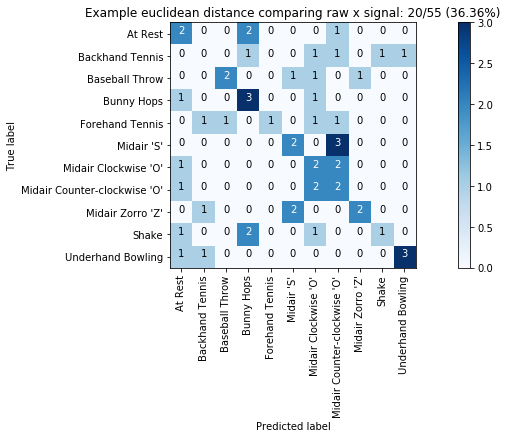

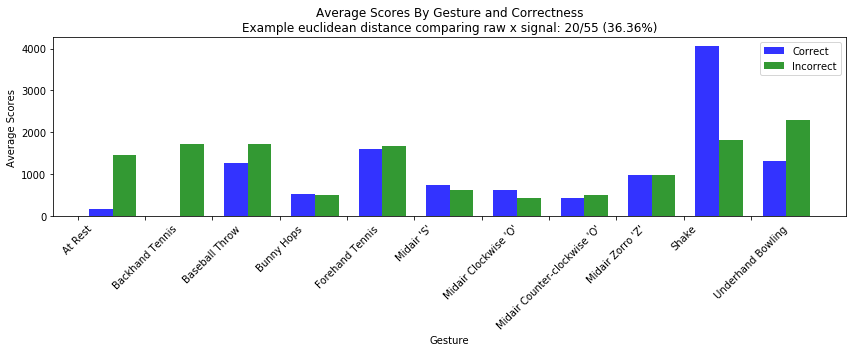

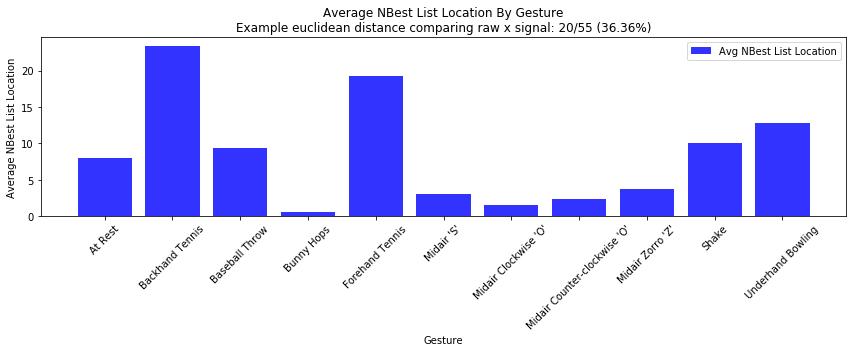

In [38]:
plot_confusion_matrix(results)
plot_bar_graph_average_scores_by_gesture(results)
plot_bar_graph_average_nbestlist_location_by_gesture(results)

# Sandbox
Everything below here is a Sandbox for you to play. You could do this in another Jupyter Notebook but I often have some cells at the bottom of my notebook that let's me experiment with and play with Python and the numpy, scipy, etc. libraries. I've added some example playground cells that I used when making the assignment.

Feel free to delete all of these cells but I thought they might be informative for you.

In [ ]:
# Demonstration of numpy arithmetic array operations
import numpy as np
x = np.array([1,2,3])
y = np.array([1,2,3])
z = np.array([1,2,3])

sum1 = np.add(x, y, z)
print(sum1)

x = np.array([1,2,3])
y = np.array([1,2,3])
z = np.array([1,2,3])

sum2 = x + y + z
print(sum2)

In [ ]:
# playing around with numpy subtraction. In order for these operations to work
# the arrays must be of the same size
np1 = np.array([1, 2, 3, 4, 5])
np2 = np.array([1, 2, 4, 5, 5])
np2 - np1

np3 = [1, 2, 3]

# the (0,2) value tells pad to pad 0 times in the front of array
# and three times to the end of array. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
np3_resized = np.pad(np3, (0, 2), 'constant', constant_values=0)
np3_resized - np2

In [ ]:
# Testing to see if the numpy 'where' method supports string matching
a = np.array(['apple', 'orange', 'apple', 'banana'])

indicesWhereThereAreApples = np.where(a == 'apple')

print (indicesWhereThereAreApples)
print (a[indicesWhereThereAreApples])

In [ ]:
# Playing around with classes in Python 3. Notice how just like in Javascript, you can add a new member variable
# just by starting to use it!

class DummyClass:
    def __init__(self, variable):
        self.testVar = variable
        

dummy = DummyClass(5)
print(dummy.testVar)
dummy.newVar = 7 # added a new member variable called newVar here. Cool!
print(dummy.newVar)
vars(dummy) # prints out the member variables of the class

In [ ]:
# Experimenting with how unpacking tuples work
testTuple = (1,2,3,4,5,6,7,8,9,10)
print(testTuple)
print(*testTuple)
print(*testTuple[5:])

In [ ]:
# Experimenting with how we delete things out of lists
import random
testDict = {"a":1, "c":3, "d":4}
a = list(testDict.keys())
print(a)
random.shuffle(a)
print(a)
del a[1]
print(a)

In [ ]:
# Playing around with how we can split up and combine lists in Python
testList = [1, 2, 3, 4, 5]
index = 4
print(testList[0:index] + testList[index + 1:5])

index = 3
print(testList[0:index] + testList[index + 1:5])

print(testList[index:])
print(testList[:index])

In [ ]:
# Find Euclidean distance between two numpy vector arrays
np1 = np.array([1, 2, 3, 4, 5])
np2 = np.array([5, 4, 3, 2, 1])

# First, we'll try numpy's way of determining Euclidean distance
# See: https://stackoverflow.com/a/1401828
npDist = np.linalg.norm(np2 - np1)
print(npDist)

# Next, we'll try scipy's way
# See: https://stackoverflow.com/a/21986532
from scipy.spatial import distance

scipyDist = distance.euclidean(np2,np1)
print(scipyDist)

In [ ]:
# detrend playground
from scipy import signal
a = np.random.rand(50) * 50
print(a)
b = np.array(range(0,50))
c = a + b

fig, axes = plt.subplots()
# axes.plot(a)
# axes.plot(b)
axes.plot(c, label="c (avg={:0.1f})".format(np.mean(c)))
c_detrended = signal.detrend(c)
axes.plot(c_detrended, label="c_detrended (avg={:0.1f})".format(np.mean(c_detrended)))
axes.legend()


In [ ]:
# Playing around with plotting confusion matrices
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = ["cat", "ant", "cat", "cat", "ant", "bird", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat", "bird"]
labels=["ant", "bird", "cat"]
cm = confusion_matrix(y_true, y_pred, labels)
plt.figure()
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix (without normalization)')

plt.figure()
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()